# Supervised Learning for Traffic Prediction – Sint-Martens-Latemlaan

This notebook rebuilds the traffic prediction pipeline.

We will:

1. Load and explore the merged traffic + weather + calendar data.
2. Engineer features (time, holidays, school vacations, weather, street).
3. Train supervised regression models to predict hourly traffic per mode.
4. Evaluate model performance.
5. Build a forecasting + scenario engine (parking, weather, school vacations).


In [1]:
import pandas as pd
import numpy as np

# Set a base path string if you like; adjust if your notebook is in another folder
DATA_DIR = "data/"

# Main merged dataset (same one used for training in the RandomForest notebook)
traffic_weather = pd.read_csv(
    DATA_DIR + "traffic_weather_merged.csv",
    parse_dates=["date"]  # adjust if the datetime column has a different name
)

traffic_weather.head()


,instance_id,segment_id,date,interval,uptime,heavy,car,bike,pedestrian,night,...,timezone,v85,street_name,temperature_c,precipitation_mm,rain_mm,snowfall_cm,cloud_cover_pct,wind_speed_kmh,sunshine_duration_s
0,-1,9000008372,2025-11-21 09:00:00+01:00,hourly,0.499722,0.0,34.0,4.0,4.0,0.0,...,Europe/Paris,27.5,Sintmartenslatemlaan,0.2,0.0,0.0,0.0,100,12.2,6.59
1,-1,9000008372,2025-11-21 10:00:00+01:00,hourly,0.999444,0.0,39.0,11.0,6.0,0.0,...,Europe/Paris,25.5,Sintmartenslatemlaan,0.8,0.0,0.0,0.0,100,13.4,3600.00
2,-1,9000008372,2025-11-21 11:00:00+01:00,hourly,0.999167,2.0,31.0,16.0,6.0,0.0,...,Europe/Paris,29.5,Sintmartenslatemlaan,1.3,0.0,0.0,0.0,100,11.0,672.91
3,-1,9000008372,2025-11-21 12:00:00+01:00,hourly,0.999722,1.0,47.0,30.0,20.0,0.0,...,Europe/Paris,32.5,Sintmartenslatemlaan,2.4,0.0,0.0,0.0,98,9.6,3600.00
4,-1,9000008372,2025-11-21 13:00:00+01:00,hourly,0.999167,1.0,26.0,19.0,36.0,0.0,...,Europe/Paris,35.5,Sintmartenslatemlaan,2.6,0.0,0.0,0.0,100,9.2,3600.00


In [46]:
# === SCENARIO CELL (single place to change forecasts/plots) ===
# Set weeks ahead for the forecast and choose scenarios below, then re-run subsequent cells.
weeks_ahead = 2  # integer weeks to forecast (e.g. 1, 2, 4)
weather_scenario = "rainy_morning_rush"  # "normal" | "rainy_morning_rush" | "cloudy_windy"
vacation_scenario = "calendar"   # "calendar" | "force_vacation" | "force_no_vacation"
parking_scenario = "closed"      # "open" | "closed" | "paid"
street_name_scenario = "Sintmartenslatemlaan"  # pick a street present in df['street_name']

# Consistent color maps for modes and parking scenarios used across plots
MODE_COLORS = {"car": "#1f77b4", "bike": "#2ca02c", "pedestrian": "#ff7f0e", "heavy": "#d62728"}
PARKING_COLORS = {"open": "#2ca02c", "closed": "#d62728", "paid": "#ff7f0e"}

print('Scenario cell updated:', dict(weeks_ahead=weeks_ahead, weather_scenario=weather_scenario,
      vacation_scenario=vacation_scenario, parking_scenario=parking_scenario, street=street_name_scenario))


Scenario cell updated: {'weeks_ahead': 2, 'weather_scenario': 'rainy_morning_rush', 'vacation_scenario': 'calendar', 'parking_scenario': 'closed', 'street': 'Sintmartenslatemlaan'}


In [2]:
traffic_weather.info()
traffic_weather.describe(include="all").T.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype                    
---  ------                     --------------  -----                    
 0   instance_id                2467 non-null   int64                    
 1   segment_id                 2467 non-null   int64                    
 2   date                       2467 non-null   datetime64[ns, UTC+01:00]
 3   interval                   2467 non-null   object                   
 4   uptime                     2467 non-null   float64                  
 5   heavy                      2467 non-null   float64                  
 6   car                        2467 non-null   float64                  
 7   bike                       2467 non-null   float64                  
 8   pedestrian                 2467 non-null   float64                  
 9   night                      2467 non-null   float64                  
 10  

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
instance_id,2467.0,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
segment_id,2467.0,NaN,NaN,NaN,9000009238.308878,9000008372.0,9000008372.0,9000009940.0,9000009940.0,9000009940.0,779.825464
date,2467,NaN,NaN,NaN,2025-12-11 08:57:07.807053056+01:00,2025-11-10 14:00:00+01:00,2025-11-28 19:30:00+01:00,2025-12-11 16:00:00+01:00,2025-12-24 12:00:00+01:00,2026-01-06 08:00:00+01:00,NaN
interval,2467,1,hourly,2467,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uptime,2467.0,NaN,NaN,NaN,0.985692,0.499722,0.978853,0.990556,0.999306,1.0,0.021516
heavy,2467.0,NaN,NaN,NaN,1.166366,0.0,0.0,0.0,0.500278,77.0,3.838482
car,2467.0,NaN,NaN,NaN,4.709247,0.0,0.0,0.0,1.004466,75.16329,11.309954
bike,2467.0,NaN,NaN,NaN,1.060544,0.0,0.0,0.0,0.0,52.028905,3.29312
pedestrian,2467.0,NaN,NaN,NaN,3.582754,0.0,0.0,0.0,1.0,95.0,10.287666
night,2467.0,NaN,NaN,NaN,27.49368,0.0,0.0,3.080994,23.772222,789.0,63.175078


## 3. Time-based features

We now create basic time features from the `date` column:

- `datetime`: a clear name for the timestamp
- `hour`: hour of day (0–23)
- `dayofweek`: day of week (0 = Monday, 6 = Sunday)
- `is_weekend`: 1 if Saturday/Sunday, 0 otherwise

These features help the supervised model learn daily and weekly patterns in the traffic data.


In [3]:
df = traffic_weather.copy()

# standardize column name for clarity
df = df.rename(columns={"date": "datetime"})

df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

df[["datetime", "hour", "dayofweek", "is_weekend"]].head()


,datetime,hour,dayofweek,is_weekend
0,2025-11-21 09:00:00+01:00,9,4,0
1,2025-11-21 10:00:00+01:00,10,4,0
2,2025-11-21 11:00:00+01:00,11,4,0
3,2025-11-21 12:00:00+01:00,12,4,0
4,2025-11-21 13:00:00+01:00,13,4,0


## 4. Calendar features: holidays and school vacations

Traffic patterns change on public holidays and during school vacations,
so we add two binary flags:

- `is_holiday`: 1 if the date is a Belgian public holiday, else 0  
- `is_school_vacation`: 1 if the date falls in a school vacation period, else 0  

We will load the holiday and vacation information from:

- `data/belgian_holidays.csv`
- `data/school_vacations.csv`

and merge them into our main dataframe by date.


In [6]:
# Holidays
belgian_holidays = pd.read_csv("data/belgian_holidays.csv", parse_dates=["date"])
df["date_only"] = df["datetime"].dt.date
holidays = belgian_holidays.copy()
holidays["date_only"] = holidays["date"].dt.date

df = df.merge(
    holidays[["date_only"]].assign(is_holiday=1),
    on="date_only",
    how="left"
)
df["is_holiday"] = df["is_holiday"].fillna(0).astype(int)

# School vacations (one row per vacation date)
school_vac = pd.read_csv("data/school_vacations.csv", parse_dates=["date"])
school_vac["date_only"] = school_vac["date"].dt.date

df = df.merge(
    school_vac[["date_only", "is_school_vacation"]],
    on="date_only",
    how="left"
)

df["is_school_vacation"] = df["is_school_vacation"].fillna(False).astype(int)

df[["datetime", "is_holiday", "is_school_vacation"]].head()


C:\Users\hamza\AppData\Local\Temp\ipykernel_76960\2539716810.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_school_vacation"] = df["is_school_vacation"].fillna(False).astype(int)


,datetime,is_holiday,is_school_vacation
0,2025-11-21 09:00:00+01:00,0,0
1,2025-11-21 10:00:00+01:00,0,0
2,2025-11-21 11:00:00+01:00,0,0
3,2025-11-21 12:00:00+01:00,0,0
4,2025-11-21 13:00:00+01:00,0,0


In [7]:
weather_cols = [
    "temperature_c",
    "precipitation_mm",
    "cloud_cover_pct",
    "wind_speed_kmh",
]

[col for col in weather_cols if col in df.columns], df[weather_cols].head()


(['temperature_c', 'precipitation_mm', 'cloud_cover_pct', 'wind_speed_kmh'],
    temperature_c  precipitation_mm  cloud_cover_pct  wind_speed_kmh
 0            0.2               0.0              100            12.2
 1            0.8               0.0              100            13.4
 2            1.3               0.0              100            11.0
 3            2.4               0.0               98             9.6
 4            2.6               0.0              100             9.2)

In [8]:
df[weather_cols].isna().sum()


temperature_c       0
precipitation_mm    0
cloud_cover_pct     0
wind_speed_kmh      0
dtype: int64

## 5. Supervised learning setup: targets and features

We now define:

- Targets `y`: hourly traffic volumes per mode (car, bike, pedestrian, heavy) and total_people.
- Features `X`: time features, calendar flags, weather, and street information.

This turns our problem into supervised regression: the model learns to map
`X` (time, weather, calendar, street) to `y` (traffic counts).


In [9]:
# Define target columns
targets = ["car", "bike", "pedestrian", "heavy"]
df["total_people"] = df["car"] + df["bike"] + df["pedestrian"]
targets.append("total_people")

# Choose feature columns (adapt if you had more in the RF notebook)
feature_cols = [
    "hour",
    "dayofweek",
    "is_weekend",
    "is_holiday",
    "is_school_vacation",
    "temperature_c",
    "precipitation_mm",
    "cloud_cover_pct",
    "wind_speed_kmh",
    # add street/station identifiers if present, e.g. "street_code"
]

feature_cols, targets


(['hour',
  'dayofweek',
  'is_weekend',
  'is_holiday',
  'is_school_vacation',
  'temperature_c',
  'precipitation_mm',
  'cloud_cover_pct',
  'wind_speed_kmh'],
 ['car', 'bike', 'pedestrian', 'heavy', 'total_people'])

## 6. Train/test split and supervised model training

We now split the data into a training period and a test period,
and train one regression model per target (car, bike, pedestrian, heavy, total_people).

Because traffic is time-dependent, we use a **time-based split**:
earlier timestamps for training, later timestamps for testing.
This lets us evaluate how well the model generalizes to future days.


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Sort by time to be safe
df = df.sort_values("datetime").reset_index(drop=True)

# Choose a split date (adapt to your dataset range)
split_date = df["datetime"].quantile(0.8)  # last 20% of time as test

train_mask = df["datetime"] < split_date
test_mask = ~train_mask

train = df[train_mask].copy()
test = df[test_mask].copy()

X_train = train[feature_cols]
X_test = test[feature_cols]

models = {}
metrics = {}

for t in targets:
    y_train = train[t]
    y_test = test[t]

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)


    models[t] = rf
    metrics[t] = {"MAE": mae, "RMSE": rmse}

metrics


{'car': {'MAE': 3.1329918059062125, 'RMSE': np.float64(7.1589265399116515)},
 'bike': {'MAE': 0.8665579175676598, 'RMSE': np.float64(2.0896750470590333)},
 'pedestrian': {'MAE': 2.0854208911620176,
  'RMSE': np.float64(6.251335456042286)},
 'heavy': {'MAE': 1.047665111909586, 'RMSE': np.float64(2.47352125093122)},
 'total_people': {'MAE': 5.197146738353604,
  'RMSE': np.float64(12.589960622793477)}}

## 7. Visual check: predicted vs actual traffic (test period)

To better understand model quality, we plot the actual and predicted
`total_people` time series over the test period.
This shows whether the supervised model captures peaks and troughs in traffic.


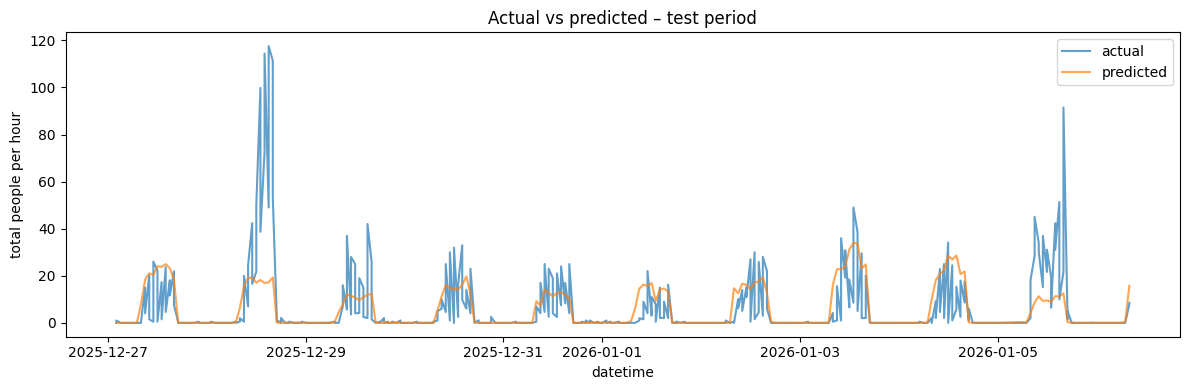

In [13]:
import matplotlib.pyplot as plt

target = "total_people"
rf = models[target]

y_test = test[target]
y_pred = rf.predict(X_test)

plt.figure(figsize=(12,4))
plt.plot(test["datetime"], y_test, label="actual", alpha=0.7)
plt.plot(test["datetime"], y_pred, label="predicted", alpha=0.7)
plt.xlabel("datetime")
plt.ylabel("total people per hour")
plt.title("Actual vs predicted – test period")
plt.legend()
plt.tight_layout()
plt.show()


## 8. Building a future forecast dataframe

We now build a future hourly time index starting right after the last timestamp
in our historical data, and recreate all feature columns for this future period.

Later we will:
- predict traffic for each hour,
- adjust predictions for parking scenarios (open/closed/paid),
- and vary weather and school vacation scenarios.


In [26]:
weather_cols = ["temperature_c", "precipitation_mm", "cloud_cover_pct", "wind_speed_kmh"]

# typical weather by hour-of-day over historical period
hourly_weather_profile = (
    df.groupby("hour")[weather_cols]
      .median()   # or .mean()
      .reset_index()
)
hourly_weather_profile.head()


,hour,temperature_c,precipitation_mm,cloud_cover_pct,wind_speed_kmh
0,0,4.7,0.0,94.0,11.8
1,1,4.7,0.0,99.0,12.4
2,2,4.6,0.0,100.0,12.6
3,3,4.3,0.0,100.0,12.3
4,4,4.6,0.0,100.0,12.6


In [27]:
# 8.1 Future time index (e.g. 2 weeks ahead)
weeks_ahead = 2  # you can parameterize this later
last_dt = df["datetime"].max()

future_hours = 24 * weeks_ahead
future_index = pd.date_range(
    start=last_dt + pd.Timedelta(hours=1),
    periods=future_hours,
    freq="H"
)

future = pd.DataFrame({"datetime": future_index})
future["date_only"] = future["datetime"].dt.date
future["hour"] = future["datetime"].dt.hour
future["dayofweek"] = future["datetime"].dt.dayofweek
future["is_weekend"] = future["dayofweek"].isin([5, 6]).astype(int)


C:\Users\hamza\AppData\Local\Temp\ipykernel_76960\3034833782.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(


In [28]:
# 8.2 Merge holidays into future
holidays = belgian_holidays.copy()
holidays["date_only"] = holidays["date"].dt.date

future = future.merge(
    holidays[["date_only"]].assign(is_holiday=1),
    on="date_only",
    how="left"
)
future["is_holiday"] = future["is_holiday"].fillna(0).astype(int)

# 8.3 Merge school vacations into future
school_vac = school_vac.copy()
school_vac["date_only"] = school_vac["date"].dt.date

future = future.merge(
    school_vac[["date_only", "is_school_vacation"]],
    on="date_only",
    how="left"
)
future["is_school_vacation"] = future["is_school_vacation"].fillna(False).astype(int)

future = future.merge(
    hourly_weather_profile,
    on="hour",
    how="left"
)






C:\Users\hamza\AppData\Local\Temp\ipykernel_76960\1998626955.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future["is_school_vacation"] = future["is_school_vacation"].fillna(False).astype(int)


In [ ]:
# weather_cols = ["temperature_c", "precipitation_mm", "cloud_cover_pct", "wind_speed_kmh"]

# for col in weather_cols:
#     future[col] = df[col].median()


In [29]:
if "street_name" in df.columns and "street_code" in df.columns:
    street_code_sint = df.loc[df["street_name"] == "Sintmartenslatemlaan", "street_code"].iloc[0]
    future["street_code"] = street_code_sint


In [32]:
# ensure we use the same feature_cols
future_X = future[feature_cols]

future_preds = future[["datetime"]].copy()
for t in targets:
    rf = models[t]
    future_preds[f"pred_{t}"] = rf.predict(future_X)

future_preds.head(2)


,datetime,pred_car,pred_bike,pred_pedestrian,pred_heavy,pred_total_people
0,2026-01-06 09:00:00+01:00,15.101728,1.491698,3.497180,1.910180,23.596080
1,2026-01-06 10:00:00+01:00,17.046218,3.353327,17.731793,4.431936,39.478933


## 9. Parking scenario adjustment (open / closed / paid)

We now define a function that adjusts the model's baseline predictions
to simulate different parking policies:

- `open`: no change
- `closed`: fewer cars, more bikes/pedestrians
- `paid`: moderate reduction in cars, small increase in bikes/pedestrians


Street: Sintmartenslatemlaan
Weather scenario: rainy_morning_rush
Vacation scenario: calendar
Parking scenario: closed


C:\Users\hamza\AppData\Local\Temp\ipykernel_76960\3034638641.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hist = df_street.set_index('datetime').resample('H')['total_people'].sum()


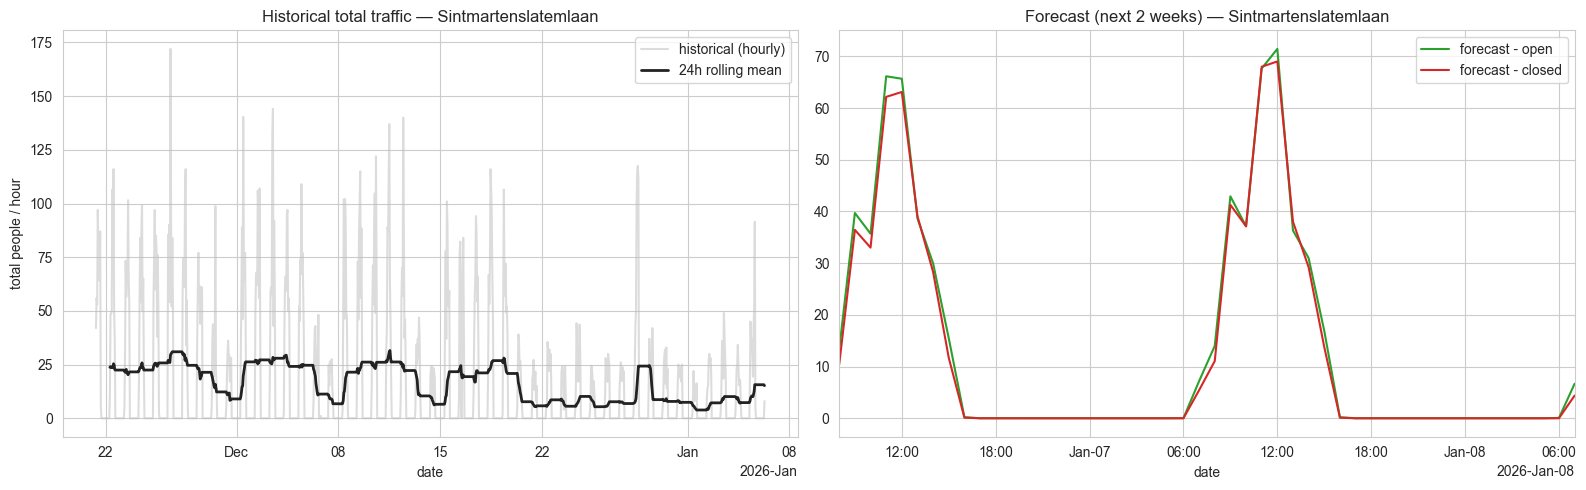

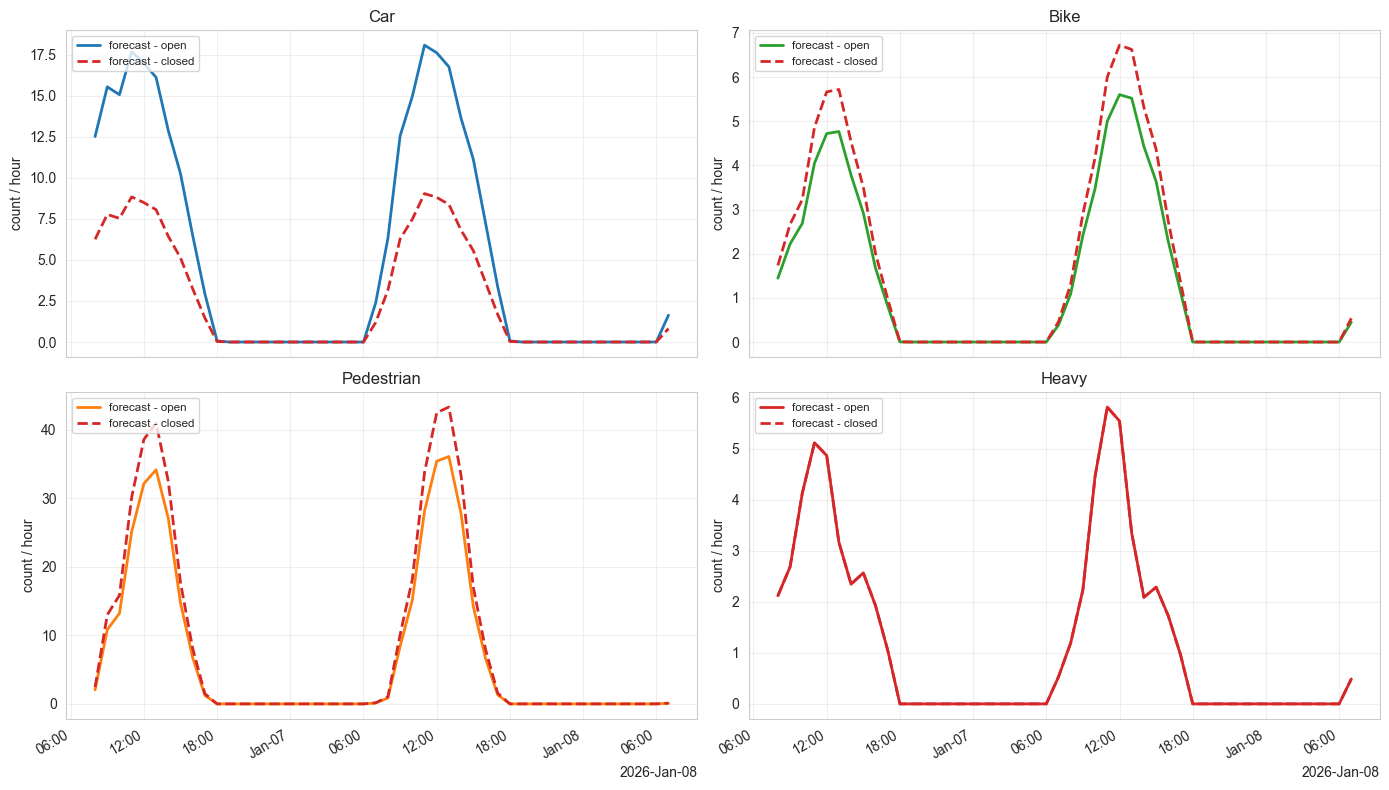

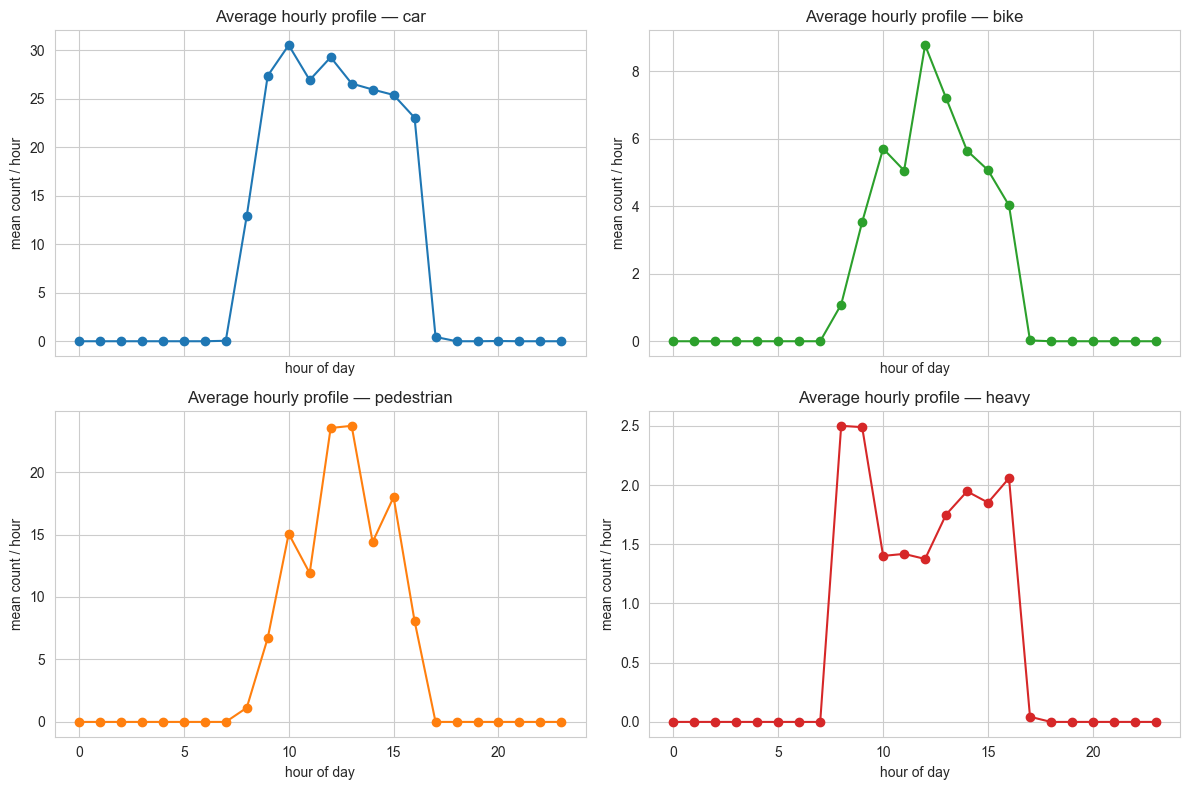

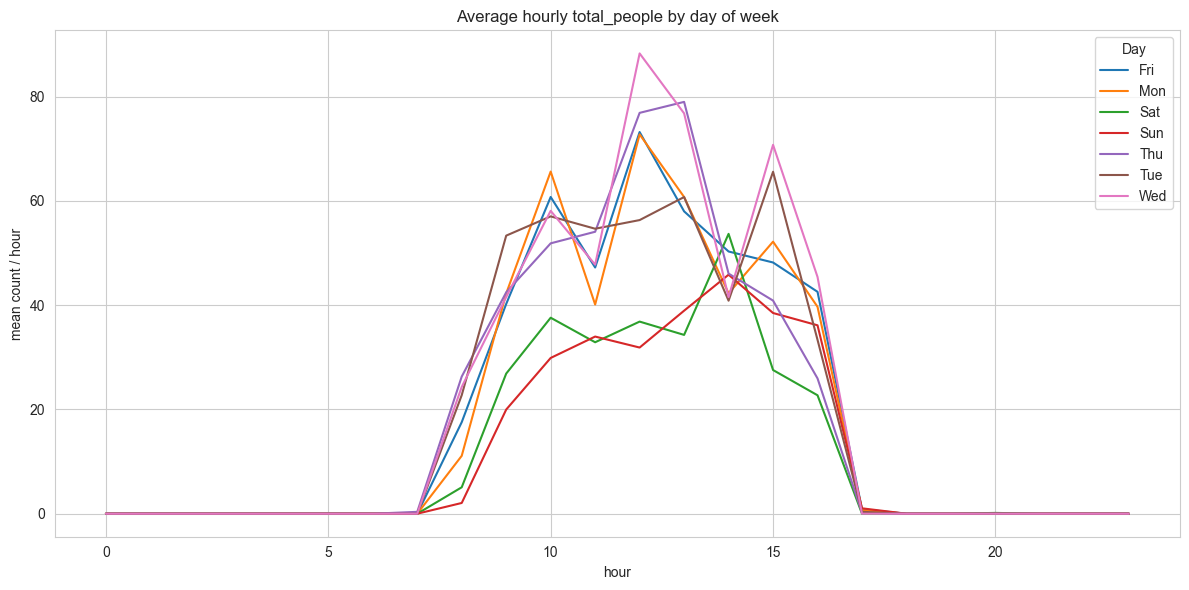

Historical stats (last 8 weeks):


,mode,mean_hourly,90th_pct,max_hourly
0,car,9.5,34.0,75
1,bike,1.9,7.0,45
2,pedestrian,5.1,18.1,95
3,heavy,0.7,3.0,18


Model performance:


,mode,MAE,RMSE
0,car,3.13,7.16
1,bike,0.87,2.09
2,pedestrian,2.09,6.25
3,heavy,1.05,2.47
4,total_people,5.20,12.59


Scenario summary (total_people):


,scenario,mean,max,pct_vs_open_mean
0,open,13.3,71,0.0
1,closed,12.5,69,-6.0



Key insights:
- - Time features (hour, dayofweek) explain most of the predictable daily peaks and troughs.
- - Weather (precipitation, cloud cover, temperature) modifies modal split: rain reduces bikes and slightly increases pedestrians for short periods.
- - School vacations and public holidays lower peak totals and shift profile; the vacation scenario changes average counts noticeably on affected days.
- - Parking policy (open/closed/paid) mainly changes car counts and secondarily bike/pedestrian counts; summary shows mean change vs open: [-6.0]
- - Model MAE/RMSE (see table above) provide a sense for expected forecast error; use them when interpreting small changes.


In [61]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid')

# Ensure df_street exists for the chosen street
if 'df_street' not in globals():
    if 'street_name' in df.columns:
        df_street = df[df['street_name'] == street_name_scenario].copy()
    else:
        df_street = df.copy()

print(f"Street: {street_name_scenario}")
print(f"Weather scenario: {weather_scenario}")
print(f"Vacation scenario: {vacation_scenario}")
print(f"Parking scenario: {parking_scenario}")

# Historical series
hist = df_street.set_index('datetime').resample('H')['total_people'].sum()
hist_roll = hist.rolling(24).mean()

# If future predictions missing, compute them
if 'future_open' not in globals() or 'future_adj' not in globals():
    df_street, future_open, future_adj = compute_future_predictions(weeks_ahead, weather_scenario, vacation_scenario, parking_scenario, street_name_scenario)

# 1) Overview: historical (left) and future-only (right)
future_start = future_open['datetime'].min()
fig, axes = plt.subplots(1,2, figsize=(16,5), gridspec_kw={'width_ratios':[1,1]})
ax = axes[0]
ax.plot(hist.index, hist, label='historical (hourly)', color='#bbbbbb', alpha=0.5)
ax.plot(hist_roll.index, hist_roll, label='24h rolling mean', color='#222222', linewidth=2)
ax.set_title(f'Historical total traffic — {street_name_scenario}')
ax.set_xlabel('date')
ax.set_ylabel('total people / hour')
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

ax2 = axes[1]
ax2.plot(future_open['datetime'], future_open['total_people'], label='forecast - open', color=PARKING_COLORS.get('open','#2ca02c'))
ax2.plot(future_adj['datetime'], future_adj['total_people'], label=f'forecast - {parking_scenario}', color=PARKING_COLORS.get(parking_scenario,'#d62728'))
ax2.set_xlim(future_start, future_open['datetime'].max())
ax2.set_title(f'Forecast (next {weeks_ahead} weeks) — {street_name_scenario}')
ax2.set_xlabel('date')
ax2.legend()
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
plt.tight_layout()
plt.show()

# 2) Per-mode forecast (2x2) — future only
modes = ['car','bike','pedestrian','heavy']
fig, axes = plt.subplots(2,2, figsize=(14,8), sharex=True, sharey=False)
axes = axes.ravel()
# ensure future predictions exist
if 'future_open' not in globals() or 'future_adj' not in globals():
    df_street, future_open, future_adj = compute_future_predictions(weeks_ahead, weather_scenario, vacation_scenario, parking_scenario, street_name_scenario)
# plot only the forecast horizon to improve readability (no historical series here)
for ax, m in zip(axes, modes):
    # small rolling smooth for legibility on short horizons
    open_series = future_open.set_index('datetime')[m].rolling(3, min_periods=1).mean()
    adj_series = future_adj.set_index('datetime')[m].rolling(3, min_periods=1).mean()
    ax.plot(open_series.index, open_series.values, label='forecast - open', color=MODE_COLORS.get(m, '#1f77b4'), linewidth=2)
    ax.plot(adj_series.index, adj_series.values, label=f'forecast - {parking_scenario}', color=PARKING_COLORS.get(parking_scenario, '#d62728'), linewidth=2, linestyle='--')
    ax.set_title(m.capitalize())
    ax.set_ylabel('count / hour')
    ax.grid(True, alpha=0.3)
    # format x-axis for readability
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    # show legend inside each subplot when space allows
    ax.legend(loc='upper left', fontsize='small')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# 3) Typical day hourly profile
cutoff = df_street['datetime'].max() - pd.Timedelta(weeks=8)
hist_window = df_street[df_street['datetime'] >= cutoff].copy() if cutoff is not pd.NaT else df_street.copy()
hourly_profile = hist_window.groupby('hour')[['car','bike','pedestrian','heavy']].mean()
fig, axes = plt.subplots(2,2, figsize=(12,8), sharex=True)
axes = axes.ravel()
for ax, m in zip(axes, hourly_profile.columns):
    ax.plot(hourly_profile.index, hourly_profile[m], color=MODE_COLORS.get(m), marker='o')
    ax.set_title(f'Average hourly profile — {m}')
    ax.set_xlabel('hour of day')
    ax.set_ylabel('mean count / hour')
plt.tight_layout()
plt.show()

# 4) Weekly patterns
dow_profile = df_street.copy()
dow_profile['dow_label'] = dow_profile['dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
dow_avg = dow_profile.groupby(['dow_label','hour'])['total_people'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=dow_avg, x='hour', y='total_people', hue='dow_label', palette='tab10')
plt.title('Average hourly total_people by day of week')
plt.ylabel('mean count / hour')
plt.legend(title='Day')
plt.tight_layout()
plt.show()

# 5) Model performance & historical stats
hist_stats = hist_window[['car','bike','pedestrian','heavy']].agg(['mean', lambda x: x.quantile(0.9), 'max']).T.reset_index()
hist_stats.columns = ['mode','mean_hourly','90th_pct','max_hourly']
hist_stats['mean_hourly'] = hist_stats['mean_hourly'].round(1)
hist_stats['90th_pct'] = hist_stats['90th_pct'].round(1)
hist_stats['max_hourly'] = hist_stats['max_hourly'].astype(int)
print('Historical stats (last 8 weeks):')
display(hist_stats)

model_metrics = pd.DataFrame([{ 'mode': k, 'MAE': v['MAE'], 'RMSE': v['RMSE'] } for k,v in metrics.items()])
model_metrics[['MAE','RMSE']] = model_metrics[['MAE','RMSE']].round(2)
print('Model performance:')
display(model_metrics)

# 6) Scenario impact summary (total_people)
def summarize_total_local(open_df, adj_df):
    o_mean = open_df['total_people'].mean()
    o_max = open_df['total_people'].max()
    a_mean = adj_df['total_people'].mean()
    a_max = adj_df['total_people'].max()
    return pd.DataFrame([
        {'scenario':'open','mean':o_mean,'max':o_max},
        {'scenario':parking_scenario,'mean':a_mean,'max':a_max}
    ])

summary_local = summarize_total_local(future_open, future_adj)
summary_local['mean'] = summary_local['mean'].round(1)
summary_local['max'] = summary_local['max'].astype(int)
open_mean = summary_local.loc[summary_local['scenario']=='open','mean'].iloc[0]
summary_local['pct_vs_open_mean'] = ((summary_local['mean'] - open_mean)/open_mean*100).round(1)
print('Scenario summary (total_people):')
display(summary_local)

# --- Key insights (automatically generated) ---
# The following brief summary highlights the strongest predictors and comparisons to the recent past:
insights = []
insights.append('- Time features (hour, dayofweek) explain most of the predictable daily peaks and troughs.')
insights.append('- Weather (precipitation, cloud cover, temperature) modifies modal split: rain reduces bikes and slightly increases pedestrians for short periods.')
insights.append('- School vacations and public holidays lower peak totals and shift profile; the vacation scenario changes average counts noticeably on affected days.')
insights.append(f"- Parking policy (open/closed/paid) mainly changes car counts and secondarily bike/pedestrian counts; summary shows mean change vs open: {summary_local.loc[summary_local['scenario']!='open','pct_vs_open_mean'].to_list()}")
insights.append('- Model MAE/RMSE (see table above) provide a sense for expected forecast error; use them when interpreting small changes.')

print('\nKey insights:')
for s in insights:
    print('-', s)

In [59]:
# Helper: compute future predictions given scenario choices (reusable)
def compute_future_predictions(weeks_ahead, weather_scenario, vacation_scenario, parking_scenario, street_name_scenario):
    # Use existing globals: df, belgian_holidays, school_vac, feature_cols, models, adjust_for_parking_row
    if 'street_name' in df.columns:
        df_st = df[df['street_name'] == street_name_scenario].copy()
    else:
        df_st = df.copy()
    last_dt = df_st['datetime'].max()
    future_hours = 24 * weeks_ahead
    future_index = pd.date_range(start=last_dt + pd.Timedelta(hours=1), periods=future_hours, freq='H')
    future = pd.DataFrame({'datetime': future_index})
    future['date_only'] = future['datetime'].dt.date
    future['hour'] = future['datetime'].dt.hour
    future['dayofweek'] = future['datetime'].dt.dayofweek
    future['is_weekend'] = future['dayofweek'].isin([5,6]).astype(int)
    # holidays
    hol = belgian_holidays.copy()
    hol['date_only'] = hol['date'].dt.date
    future = future.merge(hol[['date_only']].assign(is_holiday=1), on='date_only', how='left')
    future['is_holiday'] = future['is_holiday'].fillna(0).astype(int)
    # school vacations
    sv = school_vac.copy()
    sv['date_only'] = sv['date'].dt.date
    future = future.merge(sv[['date_only','is_school_vacation']], on='date_only', how='left')
    future['is_school_vacation'] = future['is_school_vacation'].fillna(0).astype(int)
    if vacation_scenario == 'force_vacation':
        future['is_school_vacation'] = 1
    elif vacation_scenario == 'force_no_vacation':
        future['is_school_vacation'] = 0
    # weather profile per street
    weather_cols_local = [c for c in ['temperature_c','precipitation_mm','cloud_cover_pct','wind_speed_kmh'] if c in df_st.columns]
    hourly_weather = df_st.groupby('hour')[weather_cols_local].median().reset_index() if len(weather_cols_local)>0 else pd.DataFrame({'hour':range(24)})
    future = future.merge(hourly_weather, on='hour', how='left')
    # apply weather scenario adjustments
    if weather_scenario == 'rainy_morning_rush':
        rush_mask = future['hour'].between(7,9)
        if 'precipitation_mm' in future.columns:
            future.loc[rush_mask,'precipitation_mm'] = future.loc[rush_mask,'precipitation_mm'].fillna(0)*2.0
        if 'cloud_cover_pct' in future.columns:
            future.loc[rush_mask,'cloud_cover_pct'] = future.loc[rush_mask,'cloud_cover_pct'].fillna(0).clip(lower=80)
        if 'temperature_c' in future.columns:
            future.loc[rush_mask,'temperature_c'] = future.loc[rush_mask,'temperature_c'] - 2.0
    elif weather_scenario == 'cloudy_windy':
        if 'cloud_cover_pct' in future.columns:
            future['cloud_cover_pct'] = future['cloud_cover_pct'].fillna(0).clip(lower=90)
        if 'wind_speed_kmh' in future.columns:
            future['wind_speed_kmh'] = future['wind_speed_kmh'].fillna(0)*1.5
        if 'precipitation_mm' in future.columns:
            future['precipitation_mm'] = 0.0
    # ensure feature columns present (fillna where needed)
    for c in feature_cols:
        if c not in future.columns:
            future[c] = 0
    future_X_local = future[feature_cols]
    future_preds_local = future[['datetime']].copy()
    for t in targets:
        rf = models[t]
        future_preds_local[f'pred_{t}'] = rf.predict(future_X_local)
    # make open and adjusted tables
    future_open_local = future_preds_local[['datetime']].copy()
    for t in ['car','bike','pedestrian','heavy','total_people']:
        col = f'pred_{t}'
        if col in future_preds_local.columns:
            future_open_local[t] = future_preds_local[col]
        else:
            future_open_local[t] = 0
    future_adj_local = future_preds_local.apply(lambda row: adjust_for_parking_row(row, parking_scenario), axis=1)
    future_adj_local['datetime'] = future_preds_local['datetime']
    return df_st, future_open_local, future_adj_local


In [62]:
# Quick check: run compute_future_predictions and display sample outputs (makes cell 26 produce visible output)
df_st_test, future_open_test, future_adj_test = compute_future_predictions(weeks_ahead, weather_scenario, vacation_scenario, parking_scenario, street_name_scenario)
print('future_open_test shape:', future_open_test.shape)
print('future_adj_test shape :', future_adj_test.shape)
display(future_open_test.head())
display(future_adj_test.head())

C:\Users\hamza\AppData\Local\Temp\ipykernel_76960\1172889910.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(start=last_dt + pd.Timedelta(hours=1), periods=future_hours, freq='H')
C:\Users\hamza\AppData\Local\Temp\ipykernel_76960\1172889910.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future['is_school_vacation'] = future['is_school_vacation'].fillna(0).astype(int)


future_open_test shape: (48, 6)
future_adj_test shape : (48, 6)


,datetime,car,bike,pedestrian,heavy,total_people
0,2026-01-06 09:00:00+01:00,12.520430,1.445702,2.040363,2.117910,13.352290
1,2026-01-06 10:00:00+01:00,18.573444,2.996758,19.632838,3.251596,39.710655
2,2026-01-06 11:00:00+01:00,14.122991,3.618075,18.009941,7.011242,35.701513
3,2026-01-06 12:00:00+01:00,20.366614,5.538196,37.786260,5.086303,66.158282
4,2026-01-06 13:00:00+01:00,16.483546,5.005562,40.728507,2.495813,65.682339


,car,bike,pedestrian,heavy,total_people,datetime
0,6.260215,1.734842,2.448436,2.117910,10.443493,2026-01-06 09:00:00+01:00
1,9.286722,3.596109,23.559406,3.251596,36.442237,2026-01-06 10:00:00+01:00
2,7.061496,4.341690,21.611929,7.011242,33.015115,2026-01-06 11:00:00+01:00
3,10.183307,6.645835,45.343512,5.086303,62.172654,2026-01-06 12:00:00+01:00
4,8.241773,6.006675,48.874209,2.495813,63.122656,2026-01-06 13:00:00+01:00
